In [18]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
import seaborn as sns

from helpers.linkage import *
from helpers import dataloader
from helpers.visuals import add_cabinet_periods
from helpers.networks import *
import helpers.linkage as lkg
from helpers import network_visualization as nvz

cf = yaml.safe_load(Path('config.yml').read_text())

In [19]:
# Import core data
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']
data = data['data']

# Set some lists/dictionaries for filtering
labels_reverse =dict(zip(labels.values(),labels.keys()))
indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

# Load members
mbs = pd.read_csv('helpers/members.csv',sep='\t')
name_id_dict = dict(zip(mbs.name,mbs.id))
id_name_dict = dict(zip(mbs.id,mbs.name))

# Quick function for easy lookup of speaker id's
def find_speaker(substring):
    return [(k,v) for k,v in id_name_dict.items() if substring in v.lower()]

/tmp/ipykernel_3385/4089098321.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


### Function for plotting speaker linkage network in period

In [3]:
find_speaker('zand')

[('nl.m.01594', 'P. Zandt'),
 ('nl.m.02656', 'W. (Willem) van de Zandschulp'),
 ('nl.m.01593', 'H.H. (Harrie) van der Zanden')]

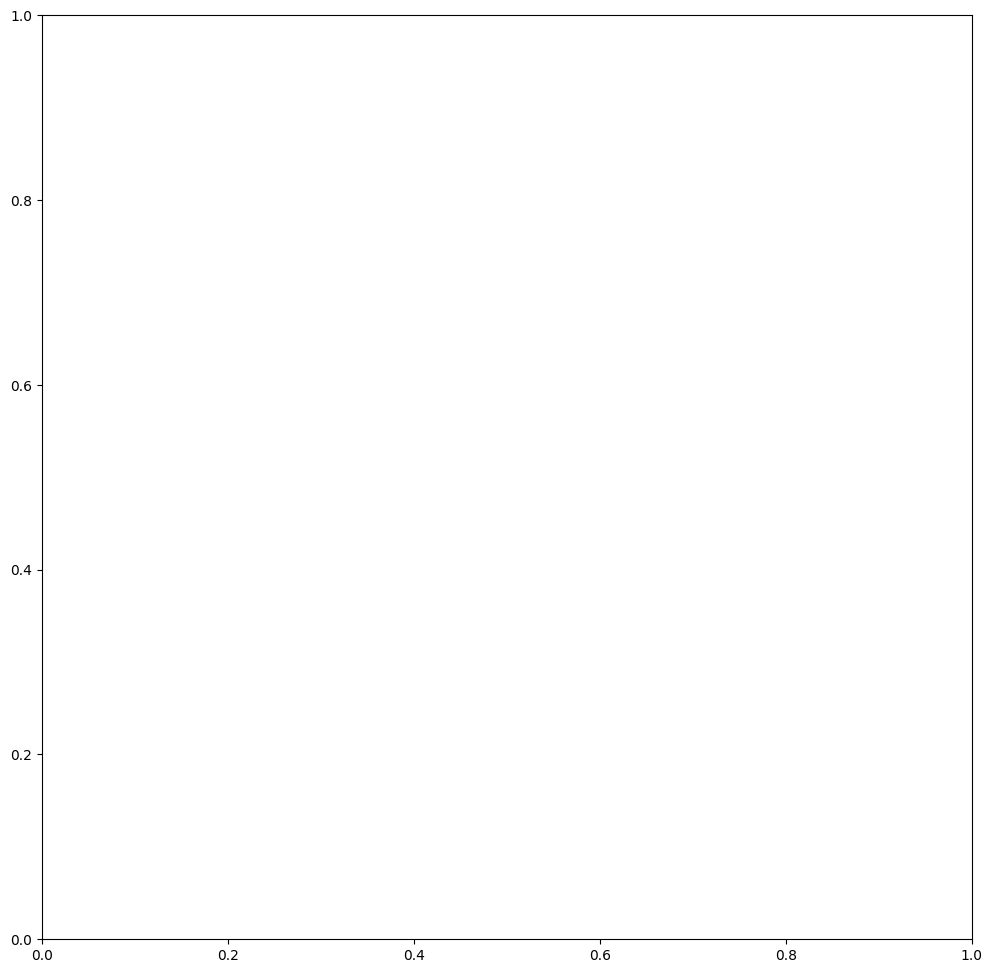

In [20]:
fig,ax = plt.subplots(1,1,figsize=(12,12))

id_ = 'nl.m.01594'
start,end = pd.Timestamp(year=1952,month=9,day=2),pd.Timestamp(year=1956,month=10,day=13)
title = id_name_dict[id_] + ' (SGP)\n' + start.strftime('%Y-%m-%d') + ' - ' + end.strftime('%Y-%m-%d')

if start != None and end != None:
    mask = (data.date > start) & (data.date <= end) & (data['member-ref'] == id_)
    data_speaker = data.loc[mask]
speaker_theta = dists.reset_index().loc[data_speaker.index].set_index('date')

# Get Normalized Topic Proportions for the speaker
speaker_theta_prop = speaker_theta.mean(axis=0).reset_index()
speaker_theta_prop.columns = ['topic_index','topic_prop_speaker']
di = dists.mean(axis=0).reset_index()
di.columns = ['topic_index','topic_prop']
speaker_theta_prop = pd.merge(di, speaker_theta_prop, on='topic_index', how='outer')
speaker_theta_prop['norm_topic_prop_speaker'] = speaker_theta_prop['topic_prop_speaker'] / speaker_theta_prop['topic_prop']
speaker_prop = dict(zip(speaker_theta_prop.topic_index,speaker_theta_prop.norm_topic_prop_speaker))

speaker_topic_selection = [k for k,v in speaker_prop.items() if v > 1]

In [22]:
dists.shape

(68617, 100)

In [24]:
dists

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
1946-01-22,0.514964,0.016305,0.003305,0.016904,0.001658,0.001384,0.009897,0.000818,0.000719,0.007179,...,0.001175,0.001714,0.004774,0.005383,0.012138,0.004181,0.006230,0.001416,0.001124,0.014963
1946-01-22,0.000050,0.000240,0.009740,0.000249,0.000024,0.000020,0.024912,0.000012,0.000011,0.000106,...,0.000017,0.000025,0.000070,0.000079,0.014177,0.044210,0.008706,0.000021,0.000017,0.021756
1946-01-22,0.002049,0.053920,0.001994,0.010197,0.001000,0.000835,0.226395,0.000493,0.000434,0.004330,...,0.000709,0.001034,0.002880,0.003247,0.007322,0.002522,0.136013,0.000854,0.000678,0.009026
1946-01-22,0.000032,0.005010,0.109625,0.030680,0.002790,0.000013,0.000094,0.000008,0.000007,0.000068,...,0.000011,0.000016,0.000045,0.000745,0.054912,0.052062,0.034047,0.000013,0.000011,0.003610
1946-01-22,0.000032,0.000155,0.046569,0.000161,0.000016,0.025019,0.007735,0.000008,0.000007,0.002152,...,0.000011,0.000016,0.003518,0.000051,0.048043,0.023656,0.000059,0.000013,0.000011,0.057794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966-12-30,0.002049,0.053920,0.001994,0.010197,0.001000,0.000835,0.005970,0.000493,0.000434,0.004330,...,0.044794,0.001034,0.002880,0.311842,0.007322,0.002522,0.003758,0.000854,0.000678,0.141281
1966-12-30,0.002964,0.014225,0.002884,0.014748,0.001446,0.001207,0.008635,0.000714,0.000627,0.006263,...,0.001026,0.001495,0.004165,0.004697,0.010590,0.003648,0.005435,0.001236,0.000981,0.523147
1966-12-30,0.002247,0.010787,0.002187,0.011183,0.001097,0.000915,0.006548,0.000541,0.000476,0.004749,...,0.000778,0.001134,0.003158,0.003561,0.008030,0.002766,0.004121,0.000937,0.000744,0.203291
